In [1]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
ets = pd.read_csv('./datasets/ncu_week_p3a.csv')
ets.head(5)

,Unnamed: 0,username,week,norm_qz_mean,norm_hw_mean,norm_mt_mean,norm_active_num_days,norm_active_avg_count,norm_active_sum_count,norm_problem_num_days,...,norm_pause_video_avg,norm_stop_video_sum,norm_stop_video_avg,norm_video_forward_seek_sum,norm_video_backward_seek_sum,norm_duration_of_first_watched_video_time_and_course_start_time,label_exam1,label_exam2,label_exam3,label_final
0,0,101302503,9.5,3.277778,1.000000,-1.000000,7.000000,6.500000,6.777778,2.277778,...,2.333333,3.500000,0.777778,3.944444,3.055556,3.444444,1.0,2.0,1.0,2.0
1,1,103602527,9.5,2.833333,1.055556,-1.000000,6.611111,7.222222,7.055556,4.055556,...,1.222222,4.111111,3.000000,4.111111,4.888889,2.888889,1.0,1.0,1.0,1.0
2,2,104602001,9.5,2.222222,1.111111,4.388889,5.611111,6.555556,6.444444,2.333333,...,2.166667,5.444444,2.944444,5.777778,2.555556,2.833333,1.0,2.0,1.0,2.0
3,3,104602002,9.5,3.444444,1.111111,4.055556,5.500000,5.944444,5.777778,0.888889,...,0.833333,2.722222,1.222222,3.166667,1.833333,2.777778,2.0,2.0,1.0,2.0
4,4,104602003,9.5,3.944444,1.000000,4.000000,6.833333,7.388889,7.277778,1.000000,...,1.777778,5.666667,2.166667,4.833333,5.055556,3.500000,1.0,2.0,1.0,1.0


In [4]:
#ets.rename(index=str, columns={"label_final": "class"}, inplace=True)
#ets.head(5)

In [5]:
#conn = MongoClient('140.115.53.147', 27017)
#conn.database_names()

In [6]:
datasets = 'NCU_ETS'

In [7]:
#db = conn[datasets]
#collection = db['ets_final_score']
#score_df = pd.DataFrame(list(collection.find()))
#score_df = score_df.drop(['_id'], axis=1)
#len(score_df)

In [8]:
#db = conn[datasets]
#collection = db['ets_all_features_by_week']
#feature_df = pd.DataFrame(list(collection.find()))
#feature_df = feature_df.drop(['_id'], axis=1)

#feature_df = feature_df.fillna('0')
#feature_df.head(5)

In [9]:
ncu_ets = ets
#ncu_ets = pd.merge(feature_df, score_df, on='username')
#ncu_ets = ncu_ets.drop(['username'], axis=1)
#ncu_ets = ncu_ets.drop(['week'], axis=1)
#ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['label_final'] == 2.0
ncu_ets = ncu_ets.drop(['label_final'], axis=1)
ncu_ets = ncu_ets.drop(['username'], axis=1)
ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.drop(['Unnamed: 0'], axis=1)
ncu_ets.head(5)

,norm_qz_mean,norm_hw_mean,norm_mt_mean,norm_active_num_days,norm_active_avg_count,norm_active_sum_count,norm_problem_num_days,norm_problem_avg_count,norm_problem_sum_count,norm_video_num_days,...,norm_pause_video_avg,norm_stop_video_sum,norm_stop_video_avg,norm_video_forward_seek_sum,norm_video_backward_seek_sum,norm_duration_of_first_watched_video_time_and_course_start_time,label_exam1,label_exam2,label_exam3,class
0,3.277778,1.000000,-1.000000,7.000000,6.500000,6.777778,2.277778,2.611111,2.111111,4.611111,...,2.333333,3.500000,0.777778,3.944444,3.055556,3.444444,1.0,2.0,1.0,True
1,2.833333,1.055556,-1.000000,6.611111,7.222222,7.055556,4.055556,3.444444,3.277778,5.611111,...,1.222222,4.111111,3.000000,4.111111,4.888889,2.888889,1.0,1.0,1.0,False
2,2.222222,1.111111,4.388889,5.611111,6.555556,6.444444,2.333333,2.111111,2.000000,5.444444,...,2.166667,5.444444,2.944444,5.777778,2.555556,2.833333,1.0,2.0,1.0,True
3,3.444444,1.111111,4.055556,5.500000,5.944444,5.777778,0.888889,0.944444,0.611111,3.888889,...,0.833333,2.722222,1.222222,3.166667,1.833333,2.777778,2.0,2.0,1.0,True
4,3.944444,1.000000,4.000000,6.833333,7.388889,7.277778,1.000000,1.000000,0.666667,5.111111,...,1.777778,5.666667,2.166667,4.833333,5.055556,3.500000,1.0,2.0,1.0,False


In [10]:

X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                        random_state=5)


In [11]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs

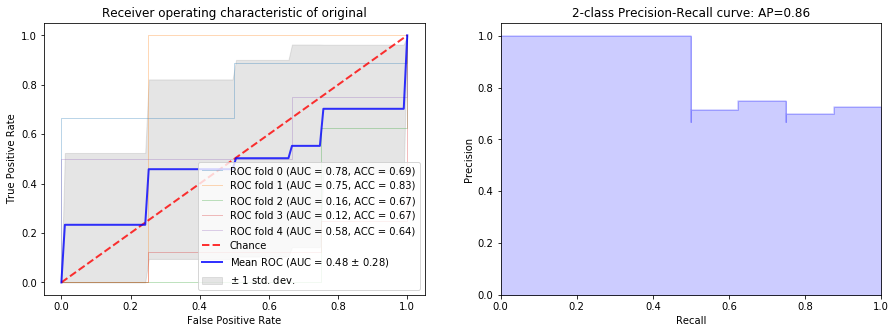

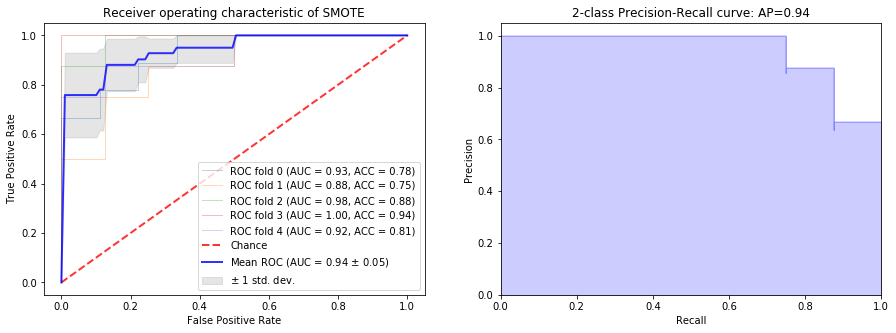

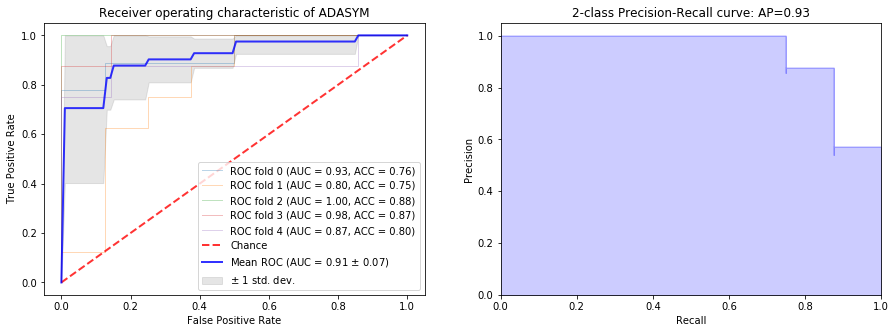

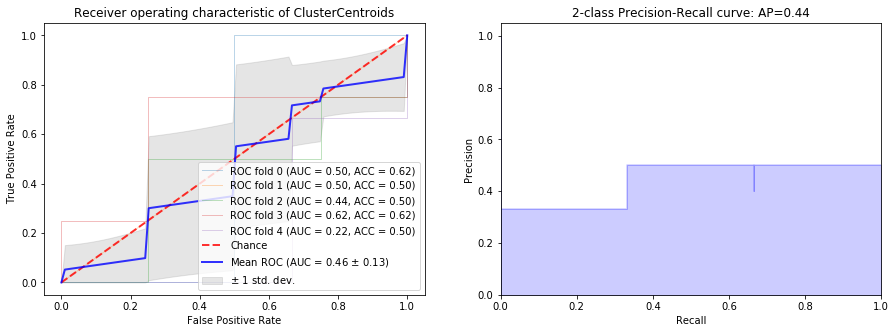

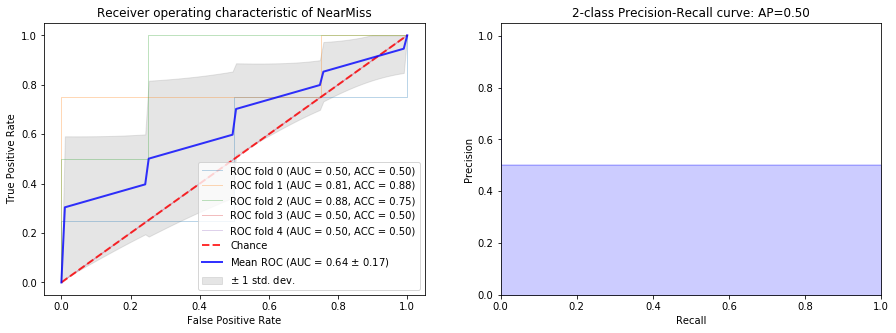

In [12]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')

In [13]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.006092890177672406
two-sample wilcoxon-test 0.006092890177672406
two-sample wilcoxon-test 0.417017614895496
two-sample wilcoxon-test 0.26290447672646966


In [14]:
y_pred = clf_binary.fit(X, y).predict_proba(X)

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
y_pred_res = clf_binary.fit(res_X, res_y).predict_proba(X)

In [15]:
temp_pd = ncu_ets
temp_pd['original'] = y_pred[:, 1].round()
temp_pd['smote'] = y_pred_res[:, 1].round()
temp_pd.head(5)

,norm_qz_mean,norm_hw_mean,norm_mt_mean,norm_active_num_days,norm_active_avg_count,norm_active_sum_count,norm_problem_num_days,norm_problem_avg_count,norm_problem_sum_count,norm_video_num_days,...,norm_stop_video_avg,norm_video_forward_seek_sum,norm_video_backward_seek_sum,norm_duration_of_first_watched_video_time_and_course_start_time,label_exam1,label_exam2,label_exam3,class,original,smote
0,3.277778,1.000000,-1.000000,7.000000,6.500000,6.777778,2.277778,2.611111,2.111111,4.611111,...,0.777778,3.944444,3.055556,3.444444,1.0,2.0,1.0,True,1.0,1.0
1,2.833333,1.055556,-1.000000,6.611111,7.222222,7.055556,4.055556,3.444444,3.277778,5.611111,...,3.000000,4.111111,4.888889,2.888889,1.0,1.0,1.0,False,0.0,0.0
2,2.222222,1.111111,4.388889,5.611111,6.555556,6.444444,2.333333,2.111111,2.000000,5.444444,...,2.944444,5.777778,2.555556,2.833333,1.0,2.0,1.0,True,1.0,1.0
3,3.444444,1.111111,4.055556,5.500000,5.944444,5.777778,0.888889,0.944444,0.611111,3.888889,...,1.222222,3.166667,1.833333,2.777778,2.0,2.0,1.0,True,1.0,1.0
4,3.944444,1.000000,4.000000,6.833333,7.388889,7.277778,1.000000,1.000000,0.666667,5.111111,...,2.166667,4.833333,5.055556,3.500000,1.0,2.0,1.0,False,1.0,0.0


In [16]:
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

<Figure size 1080x1080 with 0 Axes>

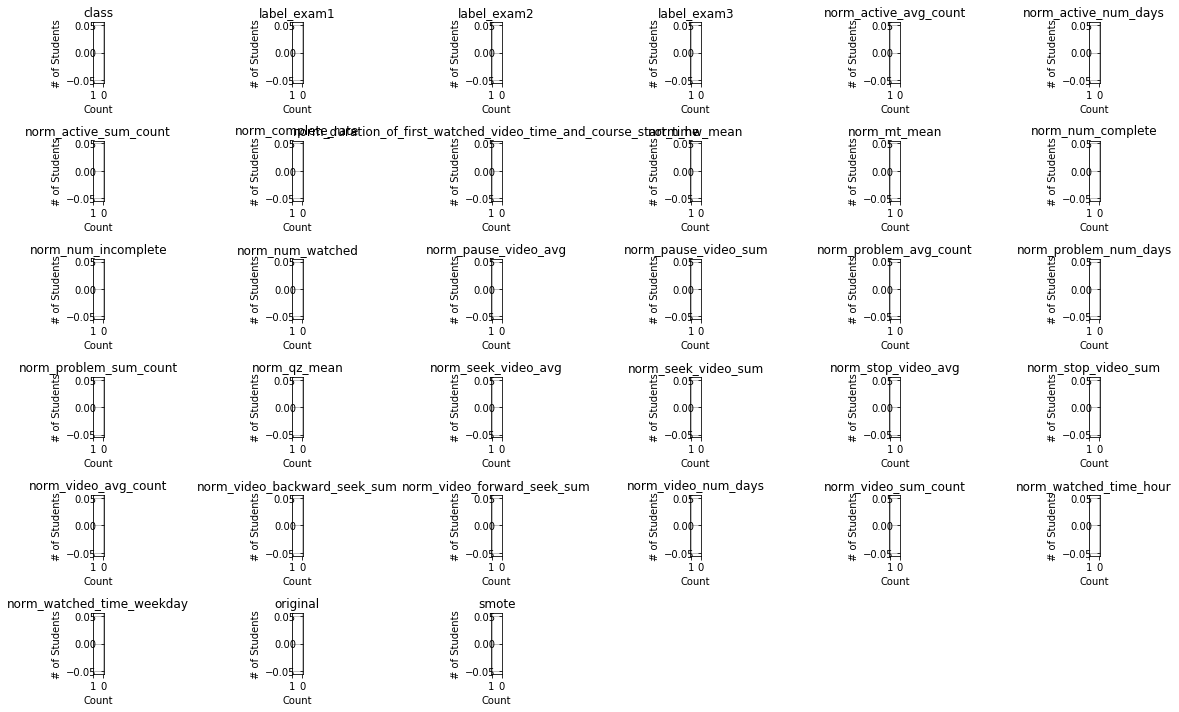

In [17]:
plt.figure(figsize=(15, 15))
ax = origin_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
plt.savefig(image_name, dpi=300)

<Figure size 1080x1080 with 0 Axes>

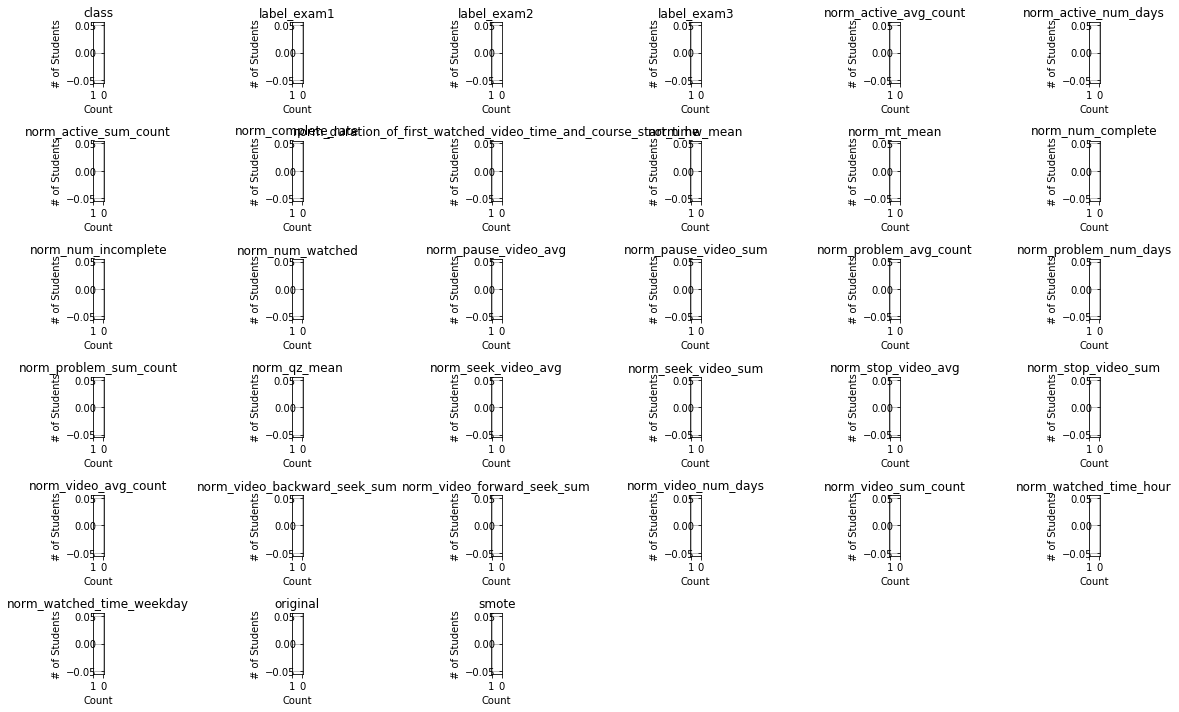

In [18]:
plt.figure(figsize=(15, 15))
ax = smote_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
plt.savefig(image_name, dpi=300)

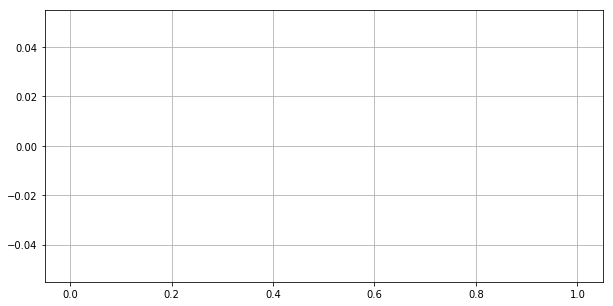

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

ax1 = smote_pd['norm_active_sum_count'].hist(alpha=0.8, bins=15)
ax1 = origin_pd['norm_active_sum_count'].hist(alpha=0.8, bins=15)

#ax1.set_ylim([0.0, 10.0])
#ax2.set_xlim([0.0, 10.0])

In [20]:
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)]))



0
0
1
40


In [21]:
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)]))

14
0
5
0


Type1: risk students been misidenfied (nop)

Type2: risk students been misidenfied, but fixed by resample (good)

Type3: risk students been identified, but misidentified by resample (bad)

Type4: risk students been identified (nop)

Type5: non-risk students been identified (nop)

Type6: non-risk students been identified, but misidentified by resample (bad)

Type7: non-risk students been misidentified, but fixed by resample (good)

Type8: non-risk students been misidentified (nop) {{a}}

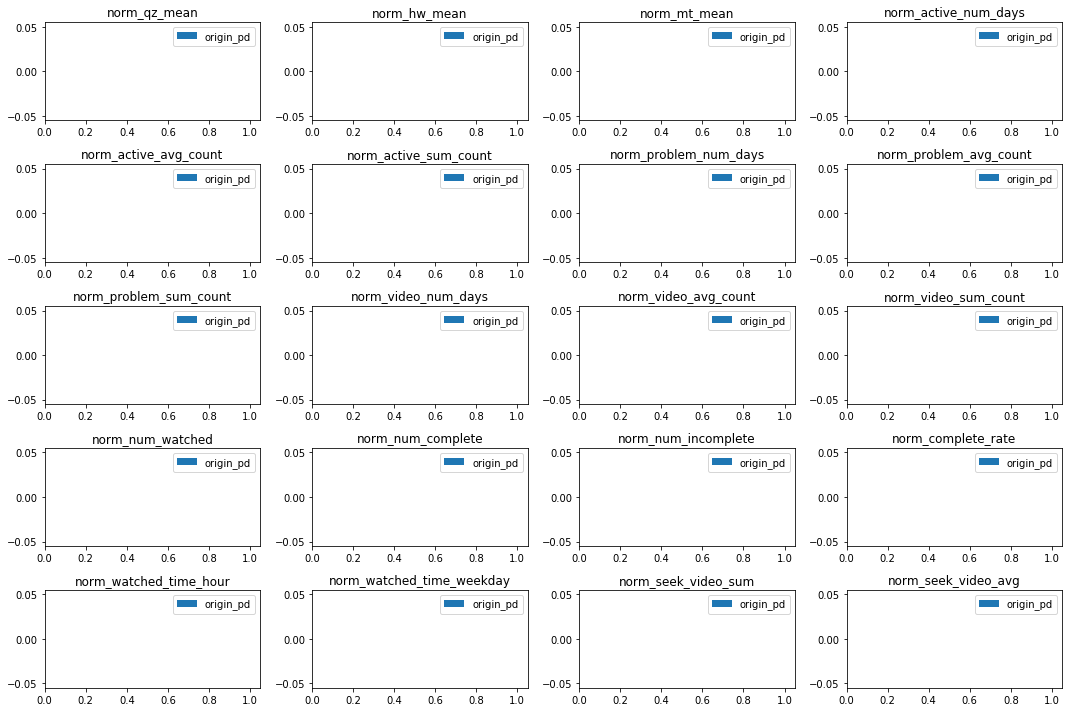

In [22]:
#data=np.random.random((4,10))
#xaxes = ['x1','x2','x3','x4']
#yaxes = ['y1','y2','y3','y4']
titles = list(origin_pd)

fig, axes = plt.subplots(5,4, figsize=(15, 10))
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd[list(origin_pd)[idx]].values, 
            smote_pd[list(smote_pd)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()
#image_name = './images/' + datasets + '_' + 'smote_identified' + '.png'
#plt.savefig(image_name, dpi=300)

In [23]:
origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

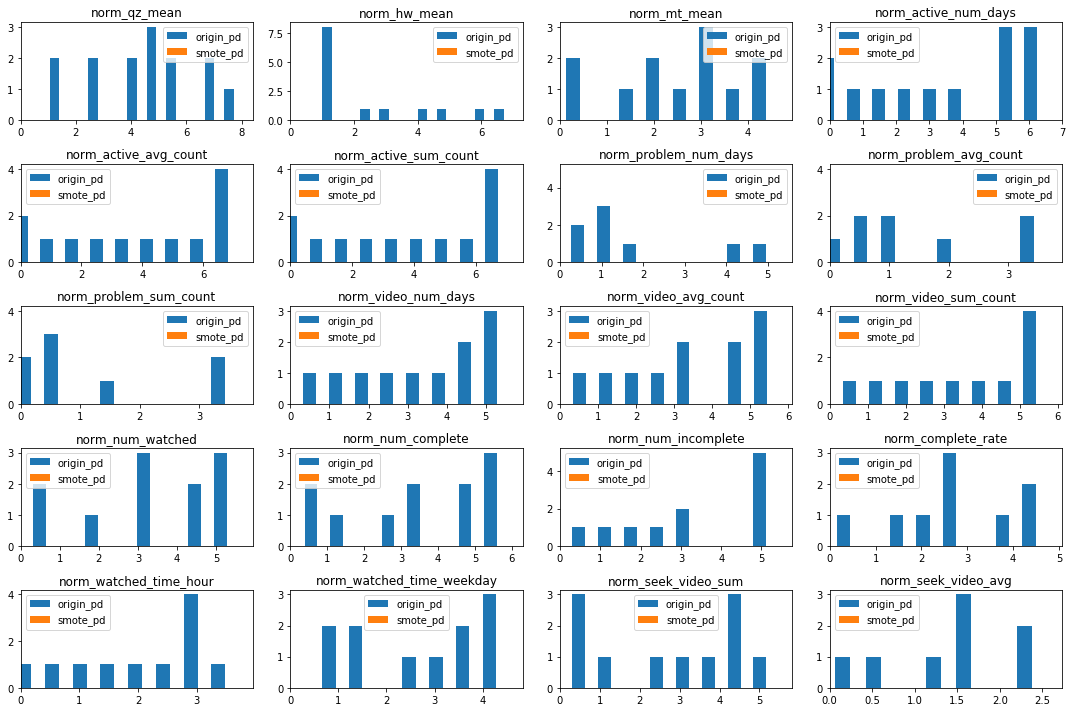

In [24]:
titles = list(origin_pd)

fig, axes = plt.subplots(5,4, figsize=(15, 10))
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd_t5[list(origin_pd_t5)[idx]].values,
            smote_pd_t6[list(smote_pd_t6)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()

#image_name = './images/' + datasets + '_' + 'smote_misidentified' + '.png'
#plt.savefig(image_name, dpi=300)

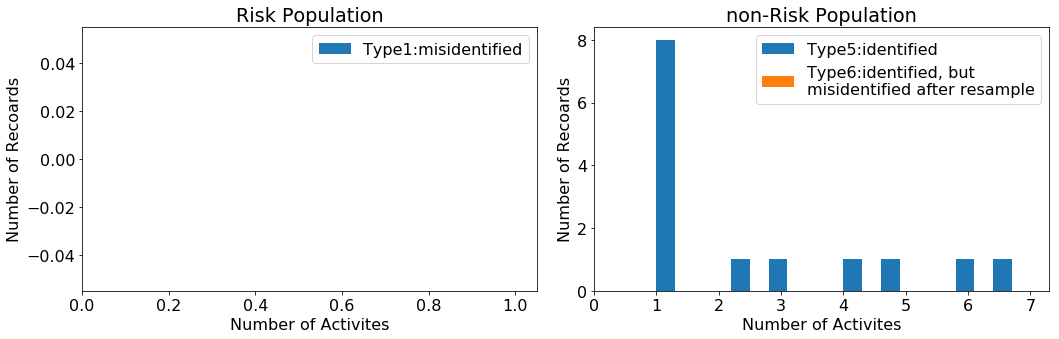

In [25]:
plt.rcParams.update({'font.size': 16})


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins=10

ax[0].hist([origin_pd[list(origin_pd)[1]].values,
            smote_pd[list(smote_pd)[1]].values],
            label=['Type1:misidentified', 'Type2:misidentified, but \nidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[0].legend()
ax[0].set_xlabel('Number of Activites')
ax[0].set_ylabel('Number of Recoards')
ax[0].set_title('Risk Population')
ax[0].set_xlim(left=0)

ax[1].hist([origin_pd_t5[list(origin_pd_t5)[1]].values,
            smote_pd_t6[list(smote_pd_t6)[1]].values],
            label=['Type5:identified', 'Type6:identified, but \nmisidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[1].legend()
ax[1].set_xlabel('Number of Activites')
ax[1].set_ylabel('Number of Recoards')
ax[1].set_title('non-Risk Population')
ax[1].set_xlim(left=0)

plt.tight_layout()
image_name = './images/' + datasets + '_' + list(origin_pd)[2] + '.png'
plt.savefig(image_name, dpi=300)